In [236]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import utils.preprocess_funcs as pf

In [37]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [263]:
colors = ['#18A558', '#A3EBB1', '#21B6A8', '#116530']

### What is the right price to set up for a new listing?

Here we consider the following case: you decided to add an object (room/appartment) to airbnb. You are new on this platform and in this business, so you are not sure what is the right price to set up. You fill all the information about the place and on the stage of putting the price you can get an advice from the system, which is based on the current proposition in your city/neighbourhood. 

Let us build a model, which will be recommend a suitable price based on your listing characteristics.

In [3]:
# select columns for modelling
numerical_columns = ['host_listings_count', 'accommodates', 'bathrooms',
                     'bedrooms', 'beds', 'square_feet', 'guests_included',
                     'minimum_nights', 'maximum_nights', 'density', 
                     'district_sentiment', 'district_rev_score']

object_columns = ['room_type', 'property_type', 'bed_type', 'instant_bookable']
inc_list_col = ['amenities']
target = ['price']

cols_to_take = numerical_columns + object_columns + inc_list_col + target

# filters on listing activity 
LAST_REVIEW_DAYS = 180
LAST_CALENDAR_UPD = 60

Read data and preprocess categorical columns

In [88]:
dataset = pd.read_pickle('Boston_Airbnb_data/preprocessed_listings.pickle')
dataset = dataset[ (dataset['recently_booked']==1) 
                & (dataset['recently_calendar_upd']==1) ]
dataset = dataset[cols_to_take]

In [89]:
# preprocess categorical columns
preprocessed = pf.add_dummy_cols(dataset, cat_cols=object_columns, dummy_na=True)
preprocessed = pf.one_hot_enc_for_amenities(preprocessed)
# fill all NaN values with -1
preprocessed = preprocessed.fillna(-1)
# preprocess column names
new_col_names = []
for col in preprocessed.columns:
    new_col_names.append(pf.preprocess_col_name(col))
    
preprocessed.columns = new_col_names

Build model

In [250]:
import lightgbm
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score

In [239]:
X = preprocessed.drop(columns=target)
y = preprocessed[target[0]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [240]:
# parameters
parameters = {
    'max_depth': [2, 3, 4, 5, 6], 
    'num_leaves': [5, 7, 8, 10],
    'n_estimators': [50, 80, 100, 120, 140]
    }

In [281]:
%%time
lgbm = LGBMRegressor(random_state=42)
clf = GridSearchCV(lgbm, parameters, cv=3)
clf.fit(X_train, y_train)

CPU times: user 1min 16s, sys: 3.35 s, total: 1min 19s
Wall time: 11.9 s


GridSearchCV(cv=3, estimator=LGBMRegressor(random_state=42),
             param_grid={'max_depth': [2, 3, 4, 5, 6],
                         'n_estimators': [50, 80, 100, 120, 140],
                         'num_leaves': [5, 7, 8, 10]})

In [283]:
best_params = clf.best_params_
print(best_params)

{'max_depth': 5, 'n_estimators': 140, 'num_leaves': 8}


In [284]:
lgbm_tuned = LGBMRegressor(**best_params, random_state=42)
lgbm_tuned.fit(X_train, y_train)
preds = lgbm_tuned.predict(X_test)
r2 = r2_score(y_test, preds)
print('R2-score =', round(r2,2))

R2-score = 0.73


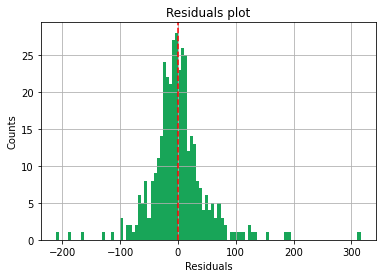

In [285]:
(y_test - preds).hist(bins=100, color=colors[0])
plt.axvline(x=(y_test - preds).mean(), color='red', linestyle='--')
plt.title('Residuals plot')
plt.ylabel('Counts')
plt.xlabel('Residuals')
plt.show()

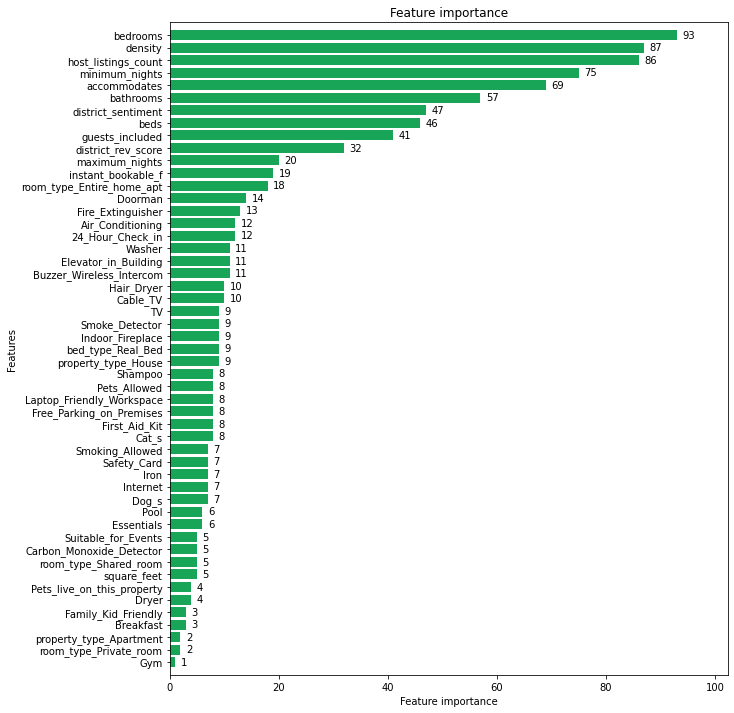

In [286]:
lightgbm.plot_importance(lgbm_tuned, 
                         figsize=(10, 12), 
                         height=0.8,
                        grid=False, 
                        color=colors[0])
plt.show()